In [2]:
import torch
import torch.utils.checkpoint
from lvdm.models.samplers.ddim import DDIMSampler
import random
import matplotlib.pyplot as plt
import numpy as np
from pytorch_lightning import seed_everything
seed_everything(42)

from omegaconf import OmegaConf
from einops import rearrange
from pytorch_lightning import seed_everything
from scripts.evaluation.initializer import *
from utils.utils import instantiate_from_config
from scripts.evaluation.funcs import load_model_checkpoint, load_prompts, load_image_batch, get_filelist, save_videos

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ckpt_path = "/home/lee_li/axton_workspace/t2v_newbet/SG-I2V/checkpoints/base_512_v2/model.ckpt"
config = "/home/lee_li/axton_workspace/t2v_newbet/SG-I2V/configs/inference_t2v_512_v2.0.yaml"
config = OmegaConf.load(config)
model_config = config.pop("model", OmegaConf.create())
model = instantiate_from_config(model_config)
model = model.to(device)
model = load_model_checkpoint(model, ckpt_path)
model.eval()
sampler = DDIMSampler(model)


/home/lee_li/miniconda3/envs/t2v/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


AE working on z of shape (1, 4, 64, 64) = 16384 dimensions.


/home/lee_li/miniconda3/envs/t2v/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


>>> model checkpoint loaded.


In [3]:
import torch
from einops import rearrange
from lvdm.models.samplers.ddim import DDIMSampler # Assuming this is in your PYTHONPATH or accessible

# You might need to ensure 'instantiate_from_config' and other utils are available
# if you load model/config from scratch within the notebook.
from utils.utils import instantiate_from_config 

def generate_video_from_prompt(
    model,  # Pre-loaded model object
    prompt_text: str,
    n_samples: int = 1,
    ddim_steps: int = 50,
    ddim_eta: float = 1.0,
    num_frames: int = -1, # -1 means use model's default temporal_length
    image_height: int = 512, # Or model.image_height if accessible
    image_width: int = 512,  # Or model.image_width if accessible
    conditioning_fps: int = 24,
    unconditional_guidance_scale: float = 7.5, # Common default, adjust as needed
    initial_noise_tensor=None, # Optional x_T
    verbose: bool = False
):
    """
    Generates video samples from a given prompt using a pre-loaded model.
    Designed for use in a Jupyter Notebook.

    Args:
        model: The loaded video generation model, should be on the correct device (e.g., model.cuda()).
        prompt_text: The text prompt to generate the video from.
        n_samples: Number of video samples to generate for this prompt.
        ddim_steps: Number of DDIM steps.
        ddim_eta: DDIM eta value.
        num_frames: Number of frames for the generated video. If -1, uses model.temporal_length.
        image_height: Height of the video in pixels.
        image_width: Width of the video in pixels.
        conditioning_fps: FPS value used for conditioning the model's temporal awareness.
        unconditional_guidance_scale: Classifier-free guidance scale.
        initial_noise_tensor: Optional initial noise tensor (x_T) with shape [1, C, T, H_latent, W_latent].
        verbose: If True, prints more debug information.

    Returns:
        A tensor containing the generated video samples in pixel space,
        shape: [n_samples, C_pixel, T, H_pixel, W_pixel].
        Returns an empty tensor if no samples are generated.
    """
    model.eval() # Ensure model is in eval mode

    if num_frames < 0:
        if hasattr(model, 'temporal_length'):
            num_frames = model.temporal_length
        else:
            raise ValueError("num_frames is -1 but model has no 'temporal_length' attribute. Please specify num_frames.")

    if not ((image_height % 16 == 0) and (image_width % 16 == 0)):
        print(f"Warning: image size ({image_height}x{image_width}) not multiples of 16. This might cause issues.")

    h_latent, w_latent = image_height // 8, image_width // 8
    channels_latent = model.channels # Latent channels

    if verbose:
        print(f"Generating video with dimensions: {num_frames}x{image_height}x{image_width}")
        print(f"Latent dimensions: {num_frames}x{h_latent}x{w_latent}, Channels: {channels_latent}")
        print(f"Prompt: {prompt_text}")

    # Prepare conditioning
    text_emb = model.get_learned_conditioning([prompt_text])
    fps_cond = torch.tensor([conditioning_fps]).to(model.device).long()
    # Ensure text_emb is on the same device as the model
    cond = {"c_crossattn": [text_emb.to(model.device)], "fps": fps_cond}


    # Noise shape for a single sample generation pass
    # The DDIMSampler inside the loop will use batch_size=1 for its internal operations for each sample
    noise_shape_per_sample = [1, channels_latent, num_frames, h_latent, w_latent]

    saved_attn_maps_per_sample = []
    
    generated_samples_list = []
    with torch.no_grad():
        for i in range(n_samples):
            if verbose:
                print(f"Generating sample {i+1}/{n_samples}...")
            ddim_sampler = DDIMSampler(model)
            uc = None # Unconditional conditioning

            if unconditional_guidance_scale != 1.0:
                uncond_type = model.uncond_type
                if uncond_type == "empty_seq":
                    prompts_uc = [""] # Empty prompt for unconditional
                    uc_emb = model.get_learned_conditioning(prompts_uc)
                elif uncond_type == "zero_embed":
                    # Use the shape of the conditional text embedding
                    c_emb_ref = cond["c_crossattn"][0]
                    uc_emb = torch.zeros_like(c_emb_ref)
                else: # Fallback or other types
                    print(f"Warning: Unknown unconditional type '{uncond_type}'. Using empty sequence.")
                    prompts_uc = [""]
                    uc_emb = model.get_learned_conditioning(prompts_uc)

                # Ensure unconditional embedding is on the correct device
                uc_emb = uc_emb.to(model.device)

                # Handle models with image embedders for unconditional part (if applicable)
                # This part is often specific to model architecture; adapt if necessary.
                if hasattr(model, 'embedder') and hasattr(model.embedder, 'input_key') and model.embedder.input_key == 'image':
                    # Example: create a dummy image for unconditional image embedding
                    # This assumes the model's get_image_embeds or similar method exists
                    # and handles the image part of unconditional conditioning.
                    # The shape [1, 3, 224, 224] is a common default for CLIP image encoders.
                    dummy_uc_img = torch.zeros(noise_shape_per_sample[0], 3, 224, 224).to(model.device)
                    if hasattr(model, 'get_image_embeds'):
                         uc_img_emb = model.get_image_embeds(dummy_uc_img)
                         uc_emb = torch.cat([uc_emb, uc_img_emb.to(model.device)], dim=1) # Concatenate text and image unconditional embeddings
                    elif verbose:
                        print("Model has an image embedder but no 'get_image_embeds' method found for unconditional part.")


                if isinstance(cond, dict):
                    uc = {key: cond[key] for key in cond.keys()} # Copy original conditions
                    uc.update({'c_crossattn': [uc_emb]}) # Override with unconditional embeddings
                else: # If `cond` was just the text_emb tensor (less common for complex models)
                    uc = uc_emb
            
            current_initial_noise = None
            if initial_noise_tensor is not None:
                # If a single noise tensor is provided for all samples, or one per sample
                if initial_noise_tensor.shape[0] == 1 and n_samples > 1: # Use same noise for all
                    current_initial_noise = initial_noise_tensor.clone()
                elif initial_noise_tensor.shape[0] == n_samples: # One specific noise per sample
                    current_initial_noise = initial_noise_tensor[i:i+1].clone()
                else: # Shape mismatch
                    print(f"Warning: initial_noise_tensor shape {initial_noise_tensor.shape} "
                          f"is not suitable for n_samples={n_samples}. Ignoring initial_noise_tensor for sample {i+1}.")
                    current_initial_noise = None

                # Validate shape of the noise to be used for the current sample
                if current_initial_noise is not None and \
                   (current_initial_noise.shape[0] != noise_shape_per_sample[0] or \
                    current_initial_noise.shape[1:] != tuple(noise_shape_per_sample[1:])):
                    print(f"Warning: Shape of current_initial_noise {current_initial_noise.shape} "
                          f"does not match expected {noise_shape_per_sample}. Using random noise for sample {i+1}.")
                    current_initial_noise = None


            sample_latent, _ = ddim_sampler.sample(
                S=ddim_steps,
                conditioning=cond,
                batch_size=noise_shape_per_sample[0], # Should be 1
                shape=noise_shape_per_sample[1:],    # C, T, H_latent, W_latent
                verbose=False, # Sampler's internal verbosity
                unconditional_guidance_scale=unconditional_guidance_scale,
                unconditional_conditioning=uc,
                eta=ddim_eta,
                temporal_length=noise_shape_per_sample[2],
                conditional_guidance_scale_temporal=None, # Typically not for single call like this
                x_T=current_initial_noise # Initial noise for this specific sample
            )
            # sample_latent shape: [1, C_latent, T, H_latent, W_latent]
            
            # Decode to pixel space
            sample_pixel = model.decode_first_stage_2DAE(sample_latent)
            # sample_pixel shape: [1, C_pixel, T, H_pixel, W_pixel]
            generated_samples_list.append(sample_pixel)

            saved_attn_maps_per_sample.append(ddim_sampler.attn_maps)
            
    if len(generated_samples_list) > 0:
        # Concatenate all generated samples along the batch dimension (dim 0)
        all_samples_tensor = torch.cat(generated_samples_list, dim=0)
        # Expected final shape: [n_samples, C_pixel, T, H_pixel, W_pixel]
    else:
        # Return an empty tensor (on the model's device) if no samples were generated
        all_samples_tensor = torch.empty(
            (0, model.out_channels if hasattr(model, 'out_channels') else 3,
             num_frames, image_height, image_width),
            device=model.device
        )
            
    if verbose:
        print(f"Generation complete. Output shape: {all_samples_tensor.shape}")
    return all_samples_tensor, saved_attn_maps_per_sample


In [4]:
prompt = "eagle"
num_videos_to_make = 1
frames_per_video = 16 # Or use model's default by passing -1
height_px = 320
width_px = 512

# Optional: Create a specific starting noise
# start_noise = torch.randn(1, C, T, H_lat, W_lat).to(my_video_model.device) # For one sample
# or
# C, T, H_lat, W_lat = my_video_model.channels, frames_per_video, height_px // 8, width_px // 8
# start_noise = torch.randn(num_videos_to_make, C, T, H_lat, W_lat).to(my_video_model.device) # For n_samples

latent_shape = [1, 4, 16, 40, 64]

latent_0 = torch.randn(latent_shape).to(device)

generated_videos_tensor, saved_attn_maps_per_sample = generate_video_from_prompt(
    model=model,
    prompt_text=prompt,
    n_samples=num_videos_to_make,
    num_frames=frames_per_video,
    image_height=height_px,
    image_width=width_px,
    ddim_steps=30,
    unconditional_guidance_scale=7.5,
    conditioning_fps=16, # Example FPS for conditioning
    verbose=True,
    initial_noise_tensor=latent_0 # Optionally pass the initial noise
)

print(f"Shape of generated videos: {generated_videos_tensor.shape}")


samples = torch.stack((generated_videos_tensor,), dim=1)
    
# 7. 保存结果
save_videos(samples, "./latent_ctrl_test/", "original", fps=16)

Generating video with dimensions: 16x320x512
Latent dimensions: 16x40x64, Channels: 4
Prompt: eagle
Generating sample 1/1...
DDIM scale True
ddim device cuda:0


/home/lee_li/miniconda3/envs/t2v/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


[DEBUG] q shape: torch.Size([80, 2560, 64])
[DEBUG] k shape: torch.Size([80, 77, 64])
[DEBUG] v shape: torch.Size([80, 77, 64])
[DEBUG] sim shape: torch.Size([80, 2560, 77])
[DEBUG] attn shape: torch.Size([80, 2560, 77])
[DEBUG] attn_maps shape: torch.Size([1, 5, 16, 40, 64, 40])
[DEBUG] q shape: torch.Size([80, 2560, 64])
[DEBUG] k shape: torch.Size([80, 77, 64])
[DEBUG] v shape: torch.Size([80, 77, 64])
[DEBUG] sim shape: torch.Size([80, 2560, 77])
[DEBUG] attn shape: torch.Size([80, 2560, 77])
[DEBUG] attn_maps shape: torch.Size([1, 5, 16, 40, 64, 40])
[DEBUG] q shape: torch.Size([160, 640, 64])
[DEBUG] k shape: torch.Size([160, 77, 64])
[DEBUG] v shape: torch.Size([160, 77, 64])
[DEBUG] sim shape: torch.Size([160, 640, 77])
[DEBUG] attn shape: torch.Size([160, 640, 77])
[DEBUG] attn_maps shape: torch.Size([1, 10, 16, 20, 32, 40])
[DEBUG] q shape: torch.Size([160, 640, 64])
[DEBUG] k shape: torch.Size([160, 77, 64])
[DEBUG] v shape: torch.Size([160, 77, 64])
[DEBUG] sim shape: torch

input_blocks.1.1.transformer_blocks.0.attn2
torch.Size([1, 5, 16, 40, 64, 40])
input_blocks.2.1.transformer_blocks.0.attn2
torch.Size([1, 5, 16, 40, 64, 40])
input_blocks.4.1.transformer_blocks.0.attn2
torch.Size([1, 10, 16, 20, 32, 40])
input_blocks.5.1.transformer_blocks.0.attn2
torch.Size([1, 10, 16, 20, 32, 40])
input_blocks.7.1.transformer_blocks.0.attn2
torch.Size([1, 20, 16, 10, 16, 40])
input_blocks.8.1.transformer_blocks.0.attn2
torch.Size([1, 20, 16, 10, 16, 40])
middle_block.1.transformer_blocks.0.attn2
torch.Size([1, 20, 16, 5, 8, 40])
output_blocks.3.1.transformer_blocks.0.attn2
torch.Size([1, 20, 16, 10, 16, 40])
output_blocks.4.1.transformer_blocks.0.attn2
torch.Size([1, 20, 16, 10, 16, 40])
output_blocks.5.1.transformer_blocks.0.attn2
torch.Size([1, 20, 16, 10, 16, 40])
output_blocks.6.1.transformer_blocks.0.attn2
torch.Size([1, 10, 16, 20, 32, 40])
output_blocks.7.1.transformer_blocks.0.attn2
torch.Size([1, 10, 16, 20, 32, 40])
output_blocks.8.1.transformer_blocks.0.at

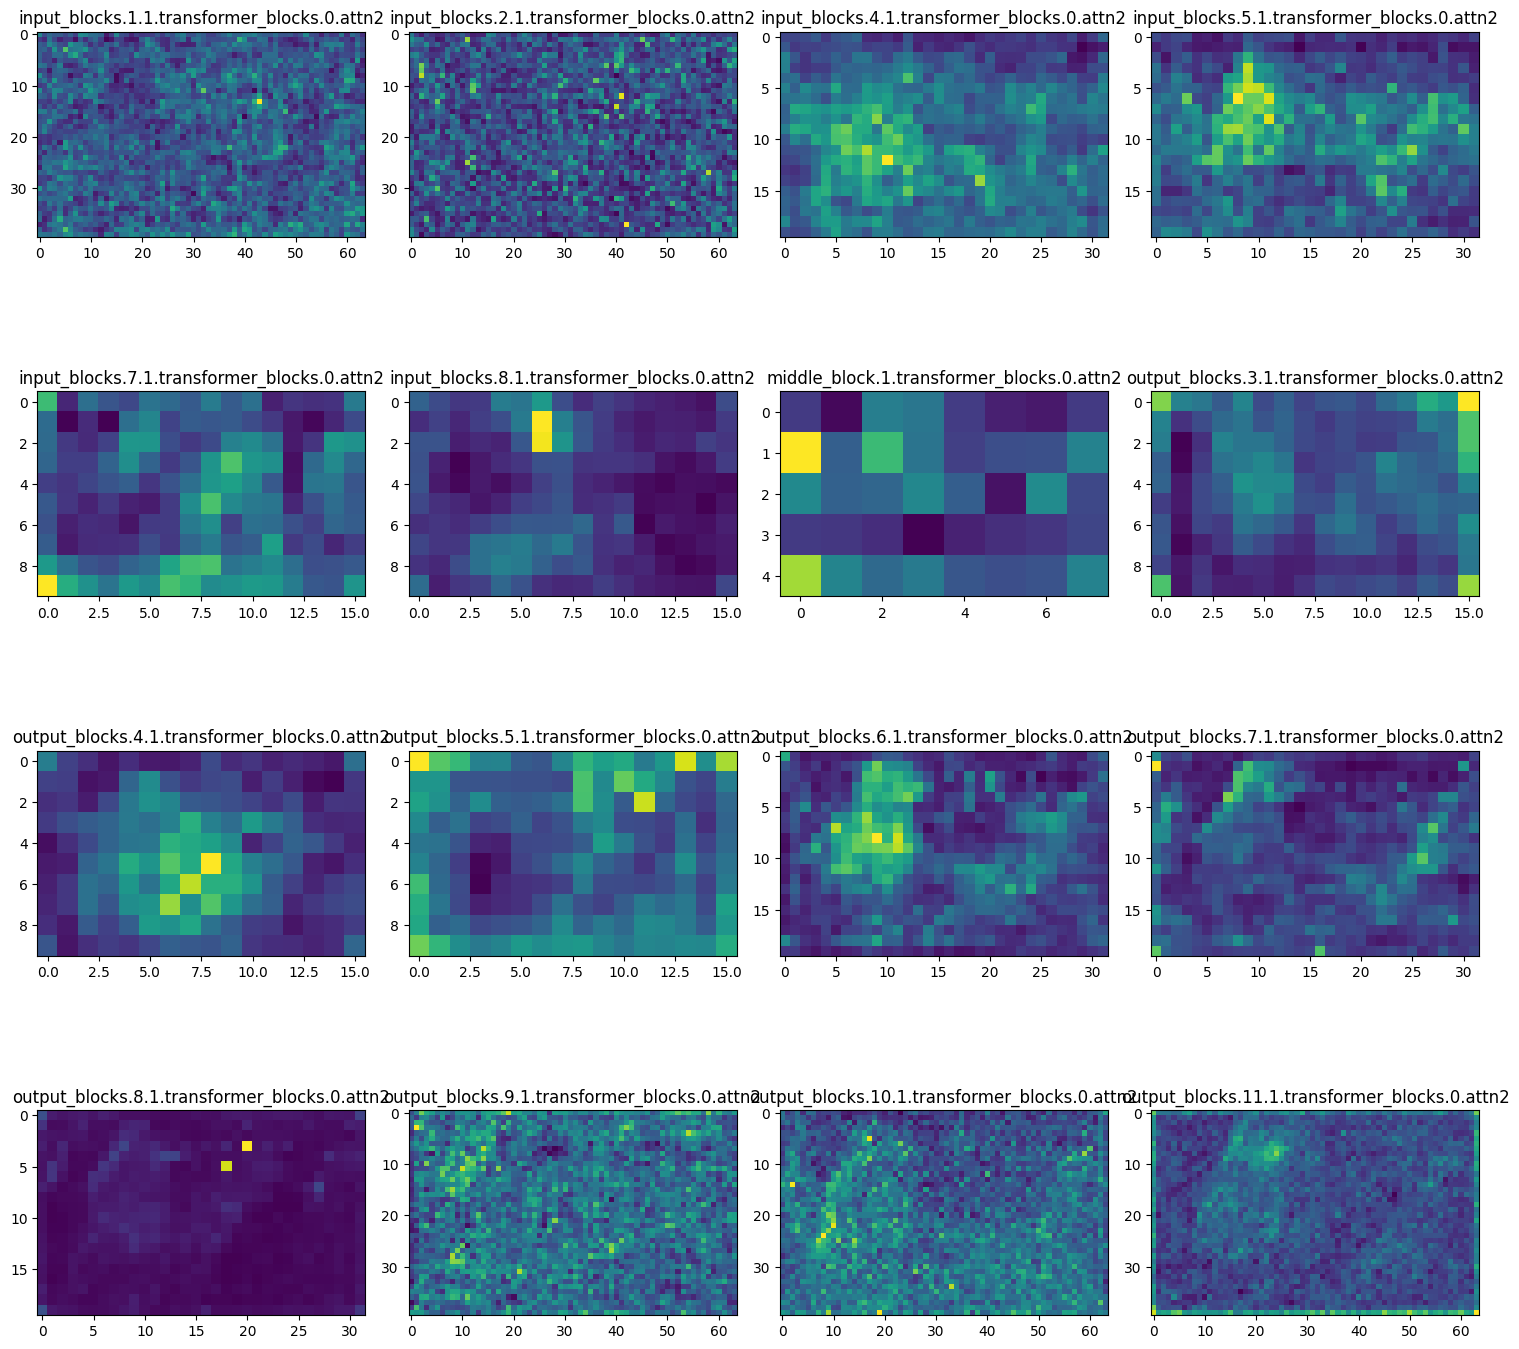

In [15]:
total_denoising_step = 29

# denoising_step = 0.9 * total_denoising_step
denoising_step = 28
# visualize all attn maps from sampler for the first frame
filtered_all_attn_maps = {k: v for k, v in saved_attn_maps_per_sample[0][denoising_step][0].items() if v[0] is not None}
filtered_all_attn_maps.keys()

for key, value in filtered_all_attn_maps.items():
    print(key)
    print(value[0].shape)
    
frame_num = 0
    
# visualize all 16 attn maps for the first frame using matplotlib
# dimension: bsz, head_num, num_frames, height, width, token_num
# average across head_num and visualize the first frame for the 2nd token

feature_maps = {}

for key, value in filtered_all_attn_maps.items():
    map_name = key
    avg_attn_map = value[0].mean(dim=1)
    
    # ditch the 1st dimension
    avg_attn_map = avg_attn_map.squeeze(0)
    
    # get the 1st frame and the 2nd token
    first_frame_attn_map = avg_attn_map[frame_num, :, :, 1]
    print(first_frame_attn_map.shape)
    
    # visualize the first frame for the 2nd token
    # plt.imshow(first_frame_attn_map)
    # plt.show()
    
    feature_maps[map_name] = first_frame_attn_map

# build a grid of 16 feature maps

# create a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

# flatten the axes array
axes = axes.ravel()

# plot each feature map
for i, (map_name, feature_map) in enumerate(feature_maps.items()):
    axes[i].imshow(feature_map)
    axes[i].set_title(map_name)
    
plt.tight_layout()
plt.show()




In [6]:
# implementation of update_latent()
def update_latent(curr_latent, attn_map, visualize=False, visualize_img_path=None, verbose=False, block_size=2, bbox_coord = [50, 0, 63, 20]):
    BLOCK_SIZE = block_size
    # bbox_coord: fm_x0, fm_y0, fm_x1, fm_y1 (FULL feature map pixel coordinates)
    latent_shape = [1, 4, 40, 64] # B, C, H_fm, W_fm 

    H_fm, W_fm = latent_shape[2], latent_shape[3]

    # Ensure H_fm and W_fm are divisible by BLOCK_SIZE for simplicity
    if H_fm % BLOCK_SIZE != 0 or W_fm % BLOCK_SIZE != 0:
        raise ValueError(f"Feature map dimensions ({H_fm}x{W_fm}) must be divisible by BLOCK_SIZE ({BLOCK_SIZE}).")

    H_block, W_block = H_fm // BLOCK_SIZE, W_fm // BLOCK_SIZE # Dimensions of the block-level attention map

    # 1. Initialize Latent Tensors
    original_latent = curr_latent.clone()
    modified_latent = original_latent.clone()

    # 2. Process Input Attention Map (expected to be at BLOCK resolution)
    # raw_block_level_attn_map = attn_map[:,:,1].squeeze() # 1: correspond to the 2nd token in the prompt
    raw_block_level_attn_map = attn_map


    block_level_attn_map = raw_block_level_attn_map.to(device)
    if verbose:
        print(f"Using block-level attention map with shape: {block_level_attn_map.shape}")
    swapped_block_level_attn_map = block_level_attn_map.clone()

    # 3. Compute Bounding Box in Block Coordinates
    fm_x0, fm_y0, fm_x1, fm_y1 = bbox_coord
    block_x_start = fm_x0 // BLOCK_SIZE
    block_y_start = fm_y0 // BLOCK_SIZE
    block_x_end = fm_x1 // BLOCK_SIZE
    block_y_end = fm_y1 // BLOCK_SIZE
    if verbose:
        print(f"Bounding box (pixels): [{fm_x0},{fm_y0}] to [{fm_x1},{fm_y1}]")
        print(f"Bounding box in block coordinates: X=[{block_x_start}, {block_x_end}), Y=[{block_y_start}, {block_y_end})")

    # 4. Determine Threshold for Swapping
    num_threshold_blocks_target = (block_y_end - block_y_start) * (block_x_end - block_x_start) // 2 # int((8 * 12) / 2)
    total_available_blocks = H_block * W_block
    num_threshold_blocks = min(num_threshold_blocks_target, total_available_blocks)
    if num_threshold_blocks <= 0 and total_available_blocks > 0 :
        num_threshold_blocks = 1
    elif total_available_blocks == 0:
        num_threshold_blocks = 0
    if verbose:
        print(f"Target number of blocks for threshold determination: {num_threshold_blocks_target}")
        print(f"Actual number of blocks for threshold (clamped to available): {num_threshold_blocks}")

    flattened_block_attn_values = block_level_attn_map.flatten()
    if num_threshold_blocks > 0 and len(flattened_block_attn_values) > 0:
        actual_threshold_idx = min(num_threshold_blocks - 1, len(flattened_block_attn_values) - 1)
        sorted_block_attn_values = torch.sort(flattened_block_attn_values, descending=True)[0]
        threshold_value = sorted_block_attn_values[actual_threshold_idx]
    elif len(flattened_block_attn_values) > 0 :
         threshold_value = flattened_block_attn_values.max() + 1
    else:
        threshold_value = -float('inf')
    if verbose:
        print(f"Attention threshold value for swapping: {threshold_value.item()}")

    # 5. Generate Swapping Candidate Lists (Sorted)
    targets_for_improvement = []
    sources_of_high_attn = []
    if total_available_blocks > 0:
        for bh in range(H_block):
            for bw in range(W_block):
                current_attn_val = block_level_attn_map[bh, bw]
                is_inside_bbox = (block_y_start <= bh < block_y_end) and \
                                 (block_x_start <= bw < block_x_end)
                if is_inside_bbox:
                    if current_attn_val < threshold_value:
                        targets_for_improvement.append({'val': current_attn_val, 'h': bh, 'w': bw})
                else:
                    if current_attn_val >= threshold_value:
                        sources_of_high_attn.append({'val': current_attn_val, 'h': bh, 'w': bw})
        targets_for_improvement.sort(key=lambda x: x['val'])
        sources_of_high_attn.sort(key=lambda x: x['val'], reverse=True)
    if verbose:
        print(f"Found {len(targets_for_improvement)} target blocks inside bbox for improvement.")
        print(f"Found {len(sources_of_high_attn)} source blocks outside bbox with high attention.")

    # 6. Perform Prioritized Swapping
    num_actual_swaps = min(len(targets_for_improvement), len(sources_of_high_attn))
    if verbose:
        print(f"Performing {num_actual_swaps} prioritized swaps.")
    for i in range(num_actual_swaps):
        target_block_info = targets_for_improvement[i]
        bh_target, bw_target = target_block_info['h'], target_block_info['w']
        source_block_info = sources_of_high_attn[i]
        bh_source, bw_source = source_block_info['h'], source_block_info['w']

        y_target_start_fm, y_target_end_fm = bh_target * BLOCK_SIZE, (bh_target + 1) * BLOCK_SIZE
        x_target_start_fm, x_target_end_fm = bw_target * BLOCK_SIZE, (bw_target + 1) * BLOCK_SIZE
        y_source_start_fm, y_source_end_fm = bh_source * BLOCK_SIZE, (bh_source + 1) * BLOCK_SIZE
        x_source_start_fm, x_source_end_fm = bw_source * BLOCK_SIZE, (bw_source + 1) * BLOCK_SIZE
        
        temp_latent_block_data = modified_latent[0, 0, y_target_start_fm:y_target_end_fm, x_target_start_fm:x_target_end_fm].clone()
        modified_latent[0, 0, y_target_start_fm:y_target_end_fm, x_target_start_fm:x_target_end_fm] = \
            modified_latent[0, 0, y_source_start_fm:y_source_end_fm, x_source_start_fm:x_source_end_fm]
        modified_latent[0, 0, y_source_start_fm:y_source_end_fm, x_source_start_fm:x_source_end_fm] = temp_latent_block_data

        temp_attn_val = swapped_block_level_attn_map[bh_target, bw_target].clone()
        swapped_block_level_attn_map[bh_target, bw_target] = swapped_block_level_attn_map[bh_source, bw_source]
        swapped_block_level_attn_map[bh_source, bw_source] = temp_attn_val
    if verbose:
        print("Prioritized swapping complete.")

    # 7. Prepare data for visualization
    upscaled_swapped_attn_map = torch.zeros((H_fm, W_fm), device=device)
    for bh in range(H_block):
        for bw in range(W_block):
            y_start_fm, y_end_fm = bh * BLOCK_SIZE, (bh + 1) * BLOCK_SIZE
            x_start_fm, x_end_fm = bw * BLOCK_SIZE, (bw + 1) * BLOCK_SIZE
            upscaled_swapped_attn_map[y_start_fm:y_end_fm, x_start_fm:x_end_fm] = swapped_block_level_attn_map[bh, bw]

    upscaled_original_attn_map = torch.zeros((H_fm, W_fm), device=device)
    for bh in range(H_block):
        for bw in range(W_block):
            y_start_fm, y_end_fm = bh * BLOCK_SIZE, (bh + 1) * BLOCK_SIZE
            x_start_fm, x_end_fm = bw * BLOCK_SIZE, (bw + 1) * BLOCK_SIZE
            upscaled_original_attn_map[y_start_fm:y_end_fm, x_start_fm:x_end_fm] = block_level_attn_map[bh, bw]

    # For latent visualization, average across channels. Latent shape: B, C, T, H_fm, W_fm
    original_latent_viz = original_latent[0, 0, :, :].mean(dim=0).cpu().numpy() # H_fm x W_fm
    modified_latent_viz = modified_latent[0, 0, :, :].mean(dim=0).cpu().numpy() # H_fm x W_fm


    if verbose:
        print(f"Shape of input block-level attention map: {block_level_attn_map.shape}")
        print(f"Shape of swapped block-level attention map: {swapped_block_level_attn_map.shape}")
        print(f"Shape of upscaled original attention map (for viz): {upscaled_original_attn_map.shape}")
        print(f"Shape of upscaled swapped attention map (for viz): {upscaled_swapped_attn_map.shape}")
        print(f"Shape of original_latent_viz: {original_latent_viz.shape}")
        print(f"Shape of modified_latent_viz: {modified_latent_viz.shape}")


    if verbose:
        print(f"Original latent sum: {original_latent.sum().item():.4f}")
        print(f"Modified latent sum: {modified_latent.sum().item():.4f}")
        if total_available_blocks > 0 and block_x_start < block_x_end and block_y_start < block_y_end:
            print(f"Original sum in bbox (block-level map) [{block_y_start}:{block_y_end}, {block_x_start}:{block_x_end}]: {block_level_attn_map[block_y_start:block_y_end, block_x_start:block_x_end].sum().item():.4f}")
            print(f"Swapped sum in bbox (block-level map) [{block_y_start}:{block_y_end}, {block_x_start}:{block_x_end}]: {swapped_block_level_attn_map[block_y_start:block_y_end, block_x_start:block_x_end].sum().item():.4f}")
        else:
            print("Bbox is empty or has zero area at block level, skipping sum in bbox.")
    
    return modified_latent


In [7]:

total_denoising_step = 30

denoising_step = 0.9 * total_denoising_step
# visualize all attn maps from sampler for the first frame
filtered_all_attn_maps = {k: v for k, v in saved_attn_maps_per_sample[0][denoising_step][0].items() if v[0] is not None}

curr_feature_maps = []


for key, value in filtered_all_attn_maps.items():
    map_name = key
    avg_attn_map = value[0].mean(dim=1)
    
    # ditch the 1st dimension
    avg_attn_map = avg_attn_map.squeeze(0)
    
    if map_name == "input_blocks.5.1.transformer_blocks.0.attn2":
        # get the 1st frame and the 2nd token
        for frame_num in range(16):
            first_frame_attn_map = avg_attn_map[frame_num, :, :, 1]
            curr_feature_maps.append(first_frame_attn_map)
    
    # visualize the first frame for the 2nd token
    # plt.imshow(first_frame_attn_map)
    # plt.show()
# use this reference attn map to realign the winning tickets in original latent

original_latent = latent_0.clone()

latent_to_be_modified = torch.zeros_like(original_latent)
for i in range(16):
    curr_attn_map = curr_feature_maps[i]  # 20, 32
    print(curr_attn_map.shape)
    curr_latent = original_latent[:, :, i, :, :]    # [1,4,40,64]

    print(curr_attn_map.shape)
    print(f"[curr_latent.shape]: {curr_latent.shape}")

    # TODO: perform swapping on this specific latent
    updated_latent = update_latent(curr_latent, curr_attn_map, verbose=True, block_size=2)
    
    # inverse the latent at dimension2
    # updated_latent = torch.flip(curr_latent, [2])
    
    
    # set the updated latent to the corresponding position in the latent_to_be_modified tensor
    latent_to_be_modified[:, :, i, :, :] = updated_latent

print(latent_to_be_modified.shape)

torch.Size([20, 32])
torch.Size([20, 32])
[curr_latent.shape]: torch.Size([1, 4, 40, 64])
Using block-level attention map with shape: torch.Size([20, 32])
Bounding box (pixels): [50,0] to [63,20]
Bounding box in block coordinates: X=[25, 31), Y=[0, 10)
Target number of blocks for threshold determination: 30
Actual number of blocks for threshold (clamped to available): 30
Attention threshold value for swapping: 0.05644655227661133
Found 60 target blocks inside bbox for improvement.
Found 30 source blocks outside bbox with high attention.
Performing 30 prioritized swaps.
Prioritized swapping complete.
Shape of input block-level attention map: torch.Size([20, 32])
Shape of swapped block-level attention map: torch.Size([20, 32])
Shape of upscaled original attention map (for viz): torch.Size([40, 64])
Shape of upscaled swapped attention map (for viz): torch.Size([40, 64])
Shape of original_latent_viz: (64,)
Shape of modified_latent_viz: (64,)
Original latent sum: 77.6773
Modified latent sum

In [8]:
prompt = "eagle"
num_videos_to_make = 1
frames_per_video = 16 # Or use model's default by passing -1
height_px = 320
width_px = 512

# Optional: Create a specific starting noise
# start_noise = torch.randn(1, C, T, H_lat, W_lat).to(my_video_model.device) # For one sample
# or
# C, T, H_lat, W_lat = my_video_model.channels, frames_per_video, height_px // 8, width_px // 8
# start_noise = torch.randn(num_videos_to_make, C, T, H_lat, W_lat).to(my_video_model.device) # For n_samples

latent_shape = [1, 4, 16, 40, 64]


generated_videos_tensor_modified, saved_attn_maps_per_sample_modified = generate_video_from_prompt(
    model=model,
    prompt_text=prompt,
    n_samples=num_videos_to_make,
    num_frames=frames_per_video,
    image_height=height_px,
    image_width=width_px,
    ddim_steps=30,
    unconditional_guidance_scale=7.5,
    conditioning_fps=16, # Example FPS for conditioning
    verbose=True,
    initial_noise_tensor=latent_to_be_modified
)

print(f"Shape of generated videos: {generated_videos_tensor_modified.shape}")


samples_modified = torch.stack((generated_videos_tensor_modified,), dim=1)
    
# 7. 保存结果
save_videos(samples_modified, "./latent_ctrl_test/", "modified", fps=16)

Generating video with dimensions: 16x320x512
Latent dimensions: 16x40x64, Channels: 4
Prompt: eagle
Generating sample 1/1...
DDIM scale True
ddim device cuda:0
[DEBUG] q shape: torch.Size([80, 2560, 64])
[DEBUG] k shape: torch.Size([80, 77, 64])
[DEBUG] v shape: torch.Size([80, 77, 64])
[DEBUG] sim shape: torch.Size([80, 2560, 77])
[DEBUG] attn shape: torch.Size([80, 2560, 77])
[DEBUG] attn_maps shape: torch.Size([1, 5, 16, 40, 64, 40])
[DEBUG] q shape: torch.Size([80, 2560, 64])
[DEBUG] k shape: torch.Size([80, 77, 64])
[DEBUG] v shape: torch.Size([80, 77, 64])
[DEBUG] sim shape: torch.Size([80, 2560, 77])
[DEBUG] attn shape: torch.Size([80, 2560, 77])
[DEBUG] attn_maps shape: torch.Size([1, 5, 16, 40, 64, 40])
[DEBUG] q shape: torch.Size([160, 640, 64])
[DEBUG] k shape: torch.Size([160, 77, 64])
[DEBUG] v shape: torch.Size([160, 77, 64])
[DEBUG] sim shape: torch.Size([160, 640, 77])
[DEBUG] attn shape: torch.Size([160, 640, 77])
[DEBUG] attn_maps shape: torch.Size([1, 10, 16, 20, 32,

input_blocks.1.1.transformer_blocks.0.attn2
torch.Size([1, 5, 16, 40, 64, 40])
input_blocks.2.1.transformer_blocks.0.attn2
torch.Size([1, 5, 16, 40, 64, 40])
input_blocks.4.1.transformer_blocks.0.attn2
torch.Size([1, 10, 16, 20, 32, 40])
input_blocks.5.1.transformer_blocks.0.attn2
torch.Size([1, 10, 16, 20, 32, 40])
input_blocks.7.1.transformer_blocks.0.attn2
torch.Size([1, 20, 16, 10, 16, 40])
input_blocks.8.1.transformer_blocks.0.attn2
torch.Size([1, 20, 16, 10, 16, 40])
middle_block.1.transformer_blocks.0.attn2
torch.Size([1, 20, 16, 5, 8, 40])
output_blocks.3.1.transformer_blocks.0.attn2
torch.Size([1, 20, 16, 10, 16, 40])
output_blocks.4.1.transformer_blocks.0.attn2
torch.Size([1, 20, 16, 10, 16, 40])
output_blocks.5.1.transformer_blocks.0.attn2
torch.Size([1, 20, 16, 10, 16, 40])
output_blocks.6.1.transformer_blocks.0.attn2
torch.Size([1, 10, 16, 20, 32, 40])
output_blocks.7.1.transformer_blocks.0.attn2
torch.Size([1, 10, 16, 20, 32, 40])
output_blocks.8.1.transformer_blocks.0.at

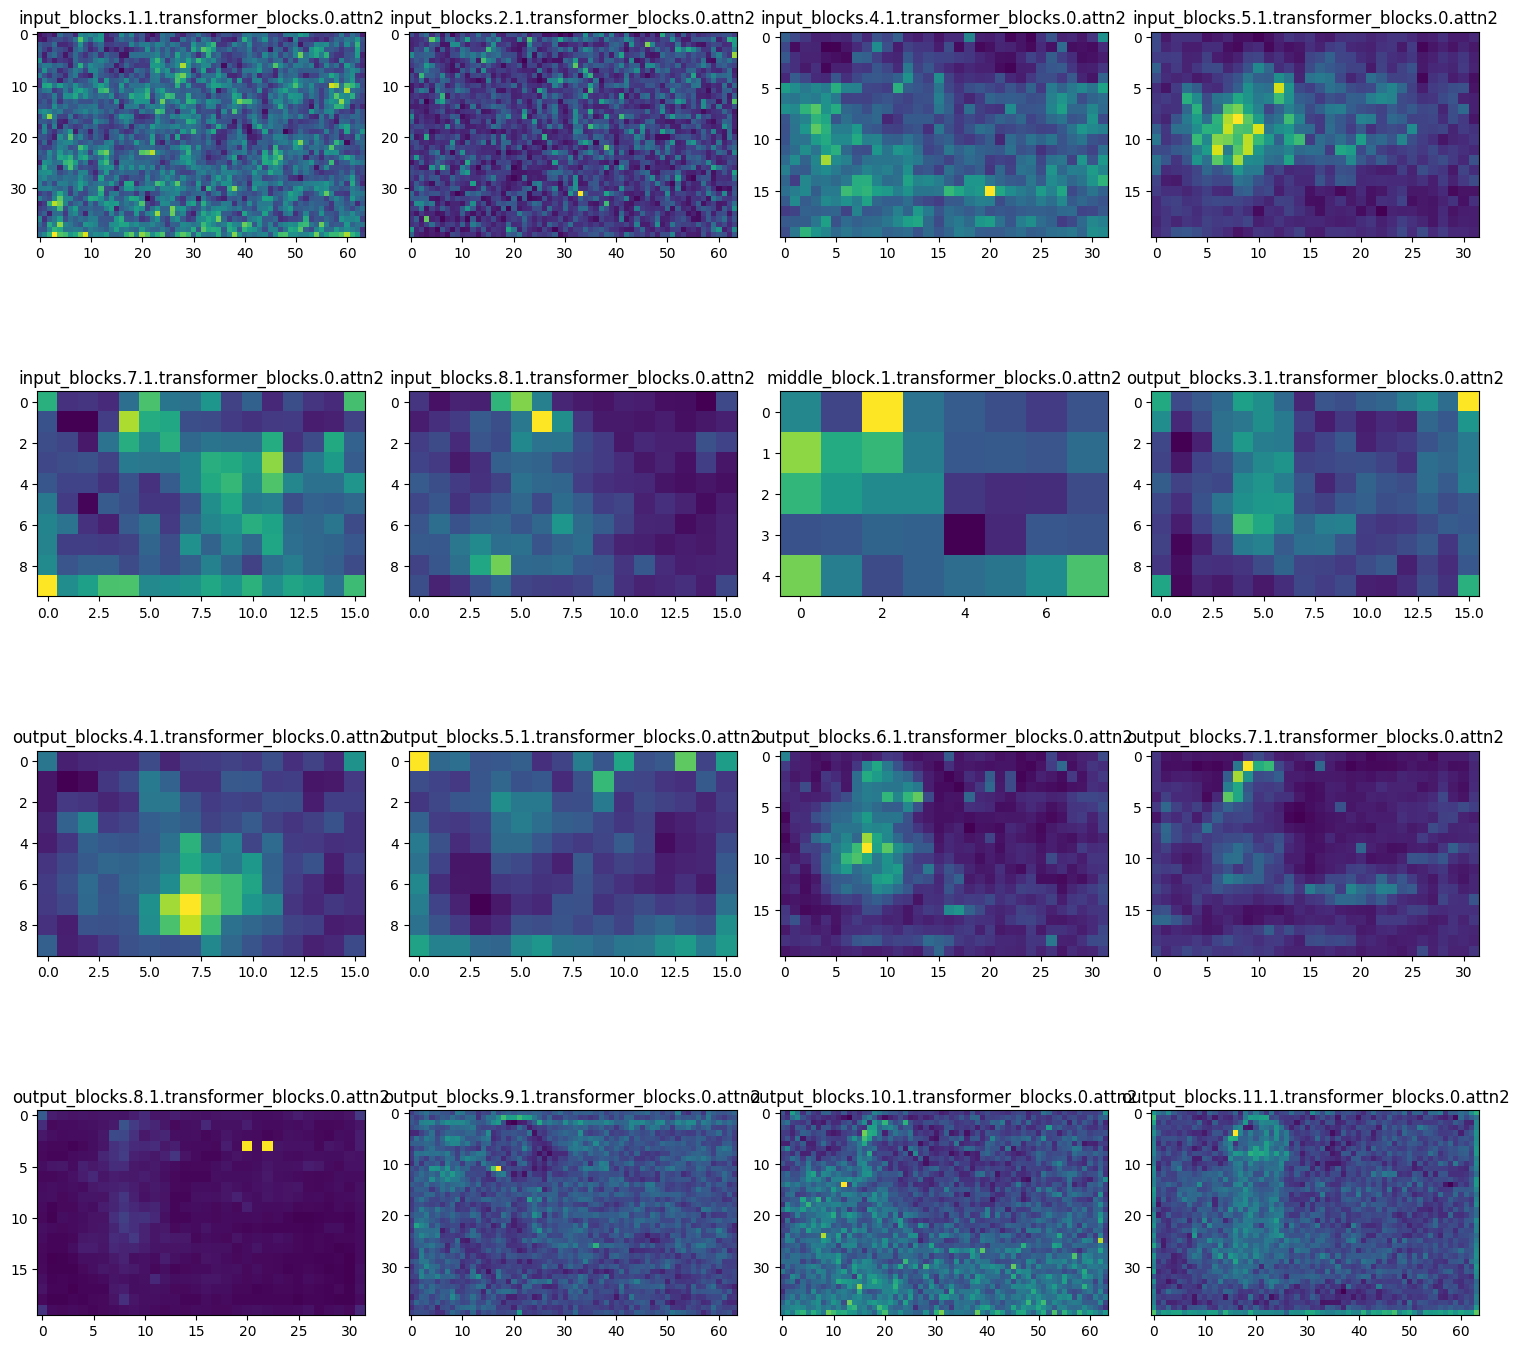

In [9]:
total_denoising_step = 30

denoising_step = 0.9 * total_denoising_step
# visualize all attn maps from sampler for the first frame
filtered_all_attn_maps = {k: v for k, v in saved_attn_maps_per_sample_modified[0][denoising_step][0].items() if v[0] is not None}
filtered_all_attn_maps.keys()

for key, value in filtered_all_attn_maps.items():
    print(key)
    print(value[0].shape)
    
frame_num = 0
    
# visualize all 16 attn maps for the first frame using matplotlib
# dimension: bsz, head_num, num_frames, height, width, token_num
# average across head_num and visualize the first frame for the 2nd token

feature_maps = {}

for key, value in filtered_all_attn_maps.items():
    map_name = key
    avg_attn_map = value[0].mean(dim=1)
    
    # ditch the 1st dimension
    avg_attn_map = avg_attn_map.squeeze(0)
    
    # get the 1st frame and the 2nd token
    first_frame_attn_map = avg_attn_map[frame_num, :, :, 1]
    print(first_frame_attn_map.shape)
    
    # visualize the first frame for the 2nd token
    # plt.imshow(first_frame_attn_map)
    # plt.show()
    
    feature_maps[map_name] = first_frame_attn_map

# build a grid of 16 feature maps

# create a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

# flatten the axes array
axes = axes.ravel()

# plot each feature map
for i, (map_name, feature_map) in enumerate(feature_maps.items()):
    axes[i].imshow(feature_map)
    axes[i].set_title(map_name)
    
plt.tight_layout()
plt.show()


